In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pydotplus
import numpy as np

from sklearn.model_selection import train_test_split
from statsmodels.graphics.correlation import plot_corr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import _tree
from sklearn.tree import export_text

from IPython.display import Image

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

dataset = pd.read_csv("dataset.csv")
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
#Age - Vek
#Anaemia - Pokles červených krviniek alebo hemoglobínu (červené krvné farbivo)
#CreatininePhosphokinase - Hladina enzýmu CPK v krvi (mcg / l)
#Diabetes - Má pacient cukrovku
#EjectionFraction - Percento krvi, ktoré opúšta srdce pri každej kontrakcii
#HighBloodPressure - Má pacient hypertenziu (vysoký krvý tlak)
#Platelets - Krvné doštičky v krvi
#SerumCreatinine - Hladina sérového kreatinínu v krvi (mg / dl)
#SerumSodium - Hodnota sérového sodíka v krvi (mEq / l)
#Sex - Žena 0, Muž 1
#Smoking - Pacient fajčí
#Time - Kontrolné obdobie v dňoch
#DeathEvent - Pacient zomrel v kontrolovanom období

dataset.columns = ['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking', 'Time', 'DeathEvent']

In [ ]:
#Dataset neobsahuje žiadne chýbajúce hodnoty
dataset.isnull().sum()

Age                        0
Anaemia                    0
CreatininePhosphokinase    0
Diabetes                   0
EjectionFraction           0
HighBloodPressure          0
Platelets                  0
SerumCreatinine            0
SerumSodium                0
Sex                        0
Smoking                    0
Time                       0
DeathEvent                 0
dtype: int64

In [ ]:
dataset.describe()

,Age,Anaemia,CreatininePhosphokinase,Diabetes,EjectionFraction,HighBloodPressure,Platelets,SerumCreatinine,SerumSodium,Sex,Smoking,Time,DeathEvent
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
#Korelačná matica nám napovie, či existuje korelácia medzi jednotlivými premennými a smrťou 
#pacienta, teda či je vôbec možné natrénovať neurónovú sieť tak, aby dokázala predpovedať smrť.
corrMat = dataset.corr(method = 'pearson')
corrMat

,Age,Anaemia,CreatininePhosphokinase,Diabetes,EjectionFraction,HighBloodPressure,Platelets,SerumCreatinine,SerumSodium,Sex,Smoking,Time,DeathEvent
Age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
Anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
CreatininePhosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
Diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
EjectionFraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
HighBloodPressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
Platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
SerumCreatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
SerumSodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
Sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


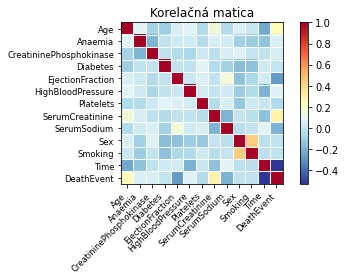

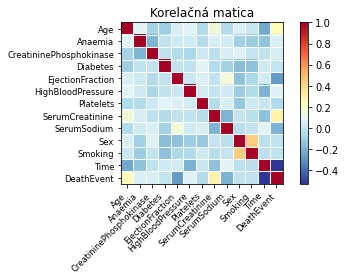

In [ ]:
#Na korelačnom grafe je možné vidieť, že najväčšiu koreláciu s premennou DeathEvent májú premenné Time (-0.52), 
#SerumCreatinine (0.29), EjectionFraction (-0.26) a Age(0.25) 

#Naopak takmer žiadna korelácia nie je medzi DeathEvent a Diabetes (-0.001), Sex (-0.004)
plot_corr(corrMat, xnames=corrMat.columns, ynames=corrMat.columns, title= 'Korelačná matica', cmap='RdYlBu_r' )

In [ ]:
#V datasete je 2x viac paciantov, ktorí prežili
dataset.DeathEvent.value_counts()

0    203
1     96
Name: DeathEvent, dtype: int64

In [ ]:
#Dáta si rozdelíme na kategorické a číselné
categoricalData = ['DeathEvent', 'Smoking', 'Sex', 'HighBloodPressure', 'Diabetes', 'Anaemia']
numericalData = ['Age', 'CreatininePhosphokinase', 'EjectionFraction', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Time']

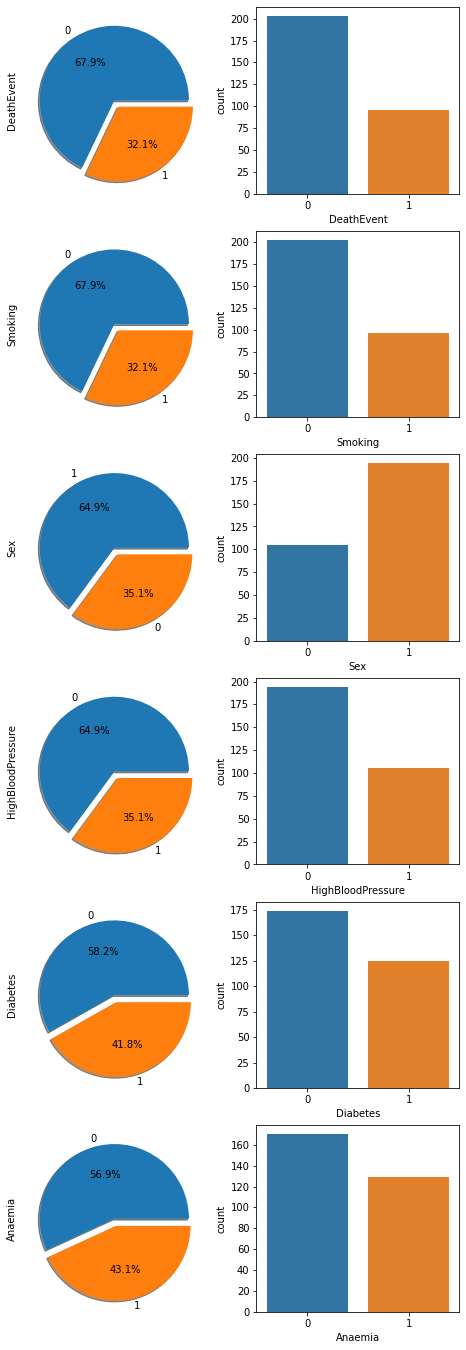

In [ ]:
#Grafické zobrazenie kateogorických dát
plt.figure(figsize=(8, 24))
count = 1
for cols in categoricalData:
  plt.subplot(6, 2, count)
  dataset[cols].value_counts().plot.pie(explode=[0,0.1], shadow=True, autopct='%1.1f%%')
  count += 1
  plt.subplot(6, 2, count)
  sns.countplot(x=cols, data=dataset)
  count += 1

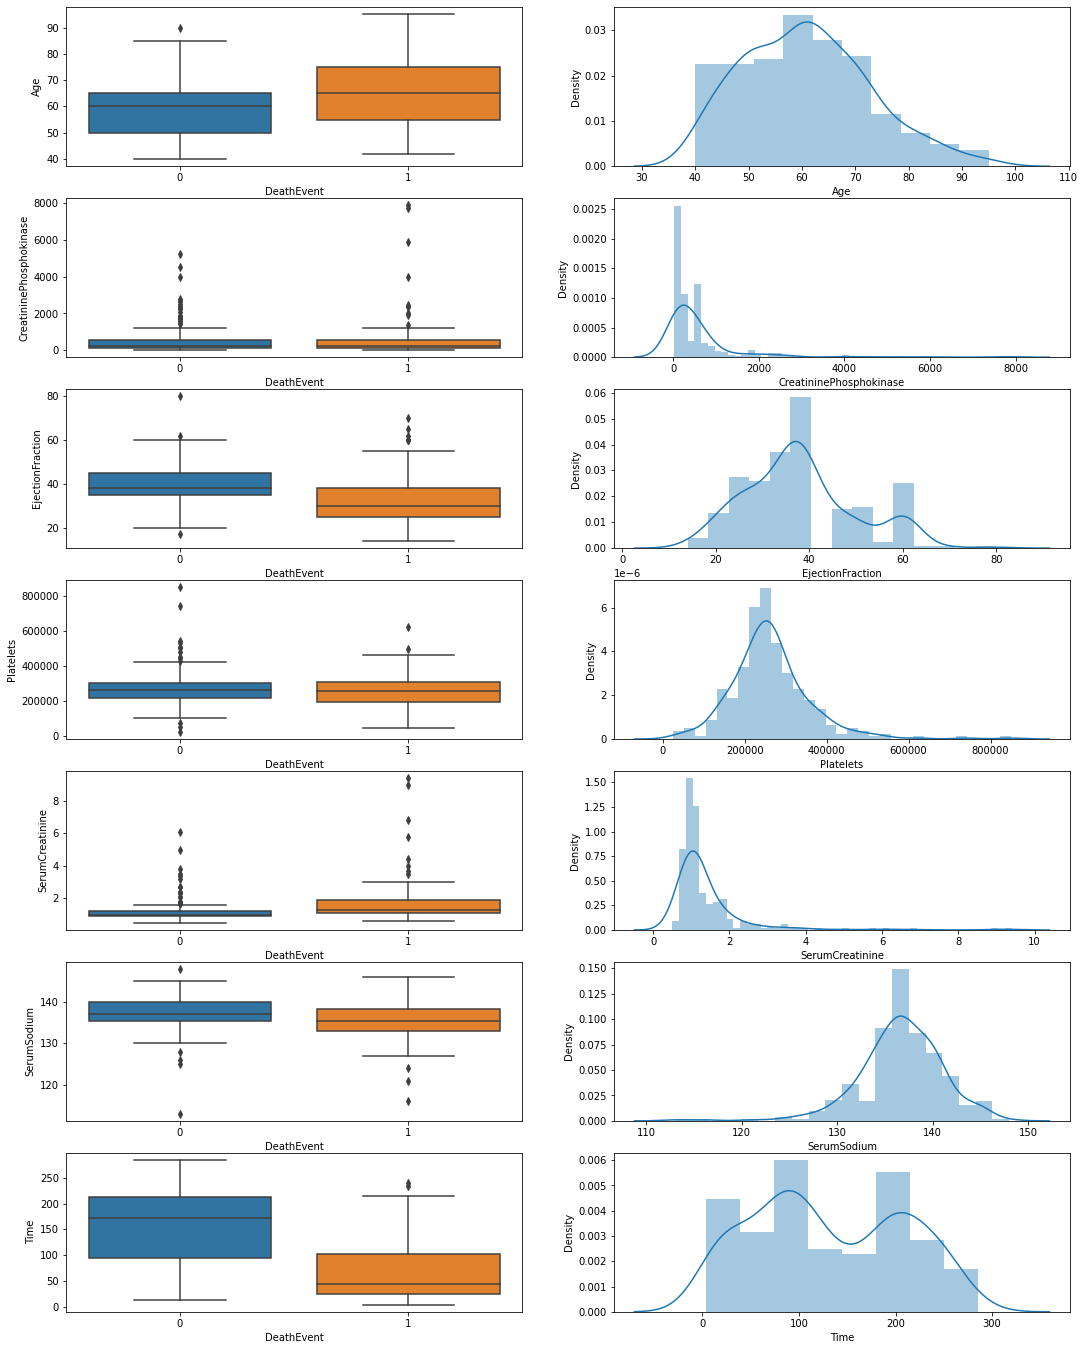

In [ ]:
#Grafické zobrazenie číselných dát
plt.figure(figsize=(18, 24))
count = 1
for cols in numericalData:
    plt.subplot(7, 2, count)
    sns.boxplot(x='DeathEvent', y= cols, data= dataset)
    count +=1
    plt.subplot(7, 2, count)
    sns.distplot(dataset.loc[dataset[cols].notna(), cols])
    count+=1

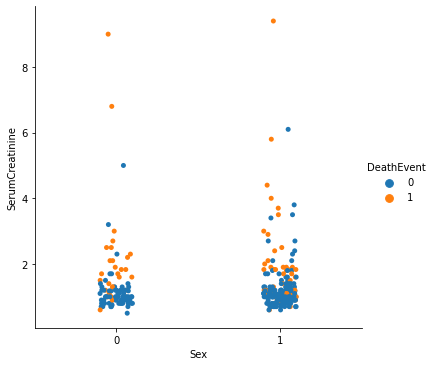

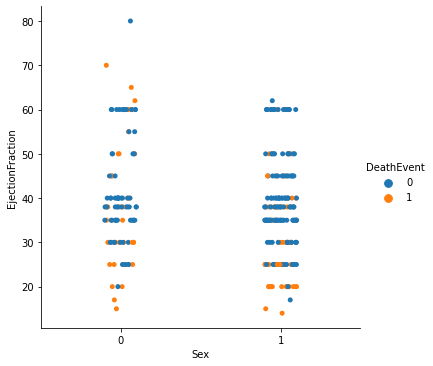

In [ ]:
#Na grafe je možné vidieť, že pacienti s vyššími hodnotami SerumCreatinine zomierali častejšie a taktiež pacienti s 
#menšími hodnotami EjectionFraction, čo dokazuje aj korelačná matica. Pohlavie na úmrtnosť nemá veľký vplyv.
sns.catplot(x='Sex', y='SerumCreatinine', data=dataset, hue='DeathEvent')
sns.catplot(x='Sex', y='EjectionFraction', data=dataset, hue='DeathEvent')

In [ ]:
#Z testu, či škálovanie pomôže k lepšiemu natrénovaniu sme zistili, že pre konkrétny dataset je lepšie dáta neškálovať.
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking', 'Time']], dataset['DeathEvent'], test_size = 0.2)

scaler = StandardScaler()

X_trainScaled = scaler.fit_transform(X_train)
X_testScaled = scaler.fit_transform(X_test)

clf = DecisionTreeClassifier()

accuracyWithScaling = []
accuracyWithoutScaling = []

for x in range(0, 500):
  clf = clf.fit(X_train,y_train)
  y_prediction = clf.predict(X_test)
  accuracyWithoutScaling.append(metrics.accuracy_score(y_test, y_prediction))

  clf = clf.fit(X_trainScaled,y_train)
  y_prediction = clf.predict(X_testScaled)
  accuracyWithScaling.append(metrics.accuracy_score(y_test, y_prediction))

avgWithScaling = sum(accuracyWithScaling) / len(accuracyWithScaling)
avgWithoutScaling = sum(accuracyWithoutScaling) / len(accuracyWithoutScaling)

print("Accuracy with scaling: " + str(avgWithScaling))
print("Accuracy without scaling: " + str(avgWithoutScaling))

Accuracy with scaling: 0.6987999999999982
Accuracy without scaling: 0.7777666666666694


In [ ]:
#Premenná Time má najväčšiu koreláciu s premenou DeathEvent, čo pomáha k lepšej predikcii úmrtí. Z dát je môžné pozorovať, že ak bol
#pacient pozorovaný menší čas (niekoľko dní) šanca na smrť je výrazne vyššia, ako v prípade, že bol pacient pod dohľadom dlhodobo.
#Údaj však môže hovoriť o fakte, že pacianti, ktorí začali pociťovať zdravotné ťažkosti začali byť kontrolovaní v čase, kedy bol ich 
#stav veľmi vážny. Zatiaľ čo pacianti bez ťažkostí sú pozorovaní dlhodobo a preto je šanca na úmrtie nižšia.
#Z dôvodu, že hodnota Time nereflektuje reálny život, túto hodnotu odstránime, čo mierne zníži úspešnosť predikcie.
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking']], dataset['DeathEvent'], test_size = 0.2)
clf = DecisionTreeClassifier()

accuracy = []

for x in range(0, 500):
  clf = clf.fit(X_train,y_train)
  y_prediction = clf.predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, y_prediction))

avg = sum(accuracy) / len(accuracy)
print("Average accuracy: " + str(avg))

Average accuracy: 0.6748666666666655


In [ ]:
#Skúška, či odstránenie dát s minimálnou koreláciou s premennou DeathEvent zvýšia presnosť predickcie
#Odstránené dáta: Smoking, Sex, Diabetes
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'Anaemia', 'CreatininePhosphokinase', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium' ]], dataset['DeathEvent'], test_size = 0.2)
clf = DecisionTreeClassifier()

accuracy = []

for x in range(0, 500):
  clf = clf.fit(X_train,y_train)
  y_prediction = clf.predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, y_prediction))

avg = sum(accuracy) / len(accuracy)
print("Average accuracy: " + str(avg))

Average accuracy: 0.6473999999999989


In [ ]:
#Skúška, či pridanie len dát z najväčšou koreláciou s premenou DeathEvent zvýši presnosť predikcie
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'EjectionFraction', 'SerumCreatinine', 'SerumSodium' ]], dataset['DeathEvent'], test_size = 0.2)
clf = DecisionTreeClassifier()

accuracy = []

for x in range(0, 500):
  clf = clf.fit(X_train,y_train)
  y_prediction = clf.predict(X_test)
  accuracy.append(metrics.accuracy_score(y_test, y_prediction))

avg = sum(accuracy) / len(accuracy)
print("Average accuracy: " + str(avg))

Average accuracy: 0.6508333333333325


In [ ]:
#Pomocou triedy GridSearchCV dokážeme zistiť najlepšie parametre pre danú sieť. 
#Funkcia nám vráti nastavenie parementrov, ktoré získalo najväčšiu presnosť
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking']], dataset['DeathEvent'], test_size = 0.2)
clf = DecisionTreeClassifier()

#Criterion - Funkcia na meranie kvality rozdelenia
#Splitter - Stratégia použitá na výber rozdelenia v každom uzle
#MaxDepth - Maximálna hĺbka stromu
#MinSamplesSplit - Minimálny počet vzoriek potrebných na rozdelenie interného uzla
#MinSamplesLeaf - Minimálny počet vzoriek, ktoré sa musia nachádzať v listovom uzle,
#MaxFeatures - Počet funkcií, ktoré je potrebné zohľadniť pri hľadaní najlepšieho rozdelenia 

param_grid = [{
  'criterion': ['gini', 'entropy'],
  'splitter': ['best', 'random'],
  'max_depth': np.arange(1,10),
  'min_samples_split': [0.001, 0.01, 0.1, 0.2, 0.02, 0.002],
  'min_samples_leaf': np.arange(1,15),
  'max_leaf_nodes': np.arange(1,10),
  'max_features': ['auto', 'sqrt', 'log2'],
  'class_weight': [None, 'balanced']
}]

clf = DecisionTreeClassifier()
grid = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=2, cv=10)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 10 folds for each of 163296 candidates, totalling 1632960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 4168 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 10664 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 19720 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 31400 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 45640 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 62504 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 81928 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 103976 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 128584 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 155816 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 185608 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 218024 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 253000 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Do

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': 8, 'min_samples_leaf': 5, 'min_samples_split': 0.1, 'splitter': 'best'}


In [ ]:
#Z testov sme zistili, že pre najlepší výsledok je vhodné dáta neškálovať a ponechať v matici aj dáta, ktoré majú menšiu 
#koreláciu s DeathEvent. Nie je nutné odstraňovať dáta, či ponechať iba najdôležitejšie dáta. Pre najlepšiu predikciu je vhodné použiť nasledovné parametre:
#{'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': 8, 'min_samples_leaf': 5, 'min_samples_split': 0.1, 'splitter': 'best'}

#Dataset rozdelíme na trénovaciu a testovaciu množinu v pomerne 8:2
X_train, X_test, y_train, y_test = train_test_split(dataset[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking']], dataset['DeathEvent'], test_size = 0.2)

clf = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=6,
    max_leaf_nodes=8,
    min_samples_leaf=5,
    min_samples_split=0.01,
    splitter='best',
    max_features='log2'
)

clf = clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_prediction))

cfm = confusion_matrix(y_test, y_prediction)
print(cfm)
print(classification_report(y_test, y_prediction))

0.7166666666666667
[[29 15]
 [ 2 14]]
              precision    recall  f1-score   support

           0       0.94      0.66      0.77        44
           1       0.48      0.88      0.62        16

    accuracy                           0.72        60
   macro avg       0.71      0.77      0.70        60
weighted avg       0.81      0.72      0.73        60



In [ ]:
#Môžeme vidieť, že celková presnosť je pomerne vysoká, no presnosť predikcie prípadu, kedy pacient zomrie je nižšia. To môže spôsobovať nedodstatok dát
#o pacientoch, ktorí zomreli. Problém môžeme vyriešiť tak, že naduplikujeme pacientov, ktorí zomreli. Duplikované dáta budú len v trénovacej časti, čo znamená
#že v testovacej budú dáta, ktoré neprešli trénovaním, takže sieť sa nemôže natrénovať priamo na daný dataset. 

#Rozdelíme si dataset na pacientov, ktorí prežili a zomreli
deathDataset = dataset[dataset['DeathEvent'] == 1]
liveDataset = dataset[dataset['DeathEvent'] == 0]

#Rozdelíme si pacientov, ktorí zomrli na trénovacích a testovacích, aby testovacie dáta neboli ovplyvnené umelo
#vytvorenými, naduplikovanými pacientmi
death_train = deathDataset[0:77]
death_test = deathDataset[78:96]

#Zdvojnásobíme počet pacientov, ktorí zomreli, čím sa počet mŕtvych a živých pacientov v datasete takmer vyrovná
death_train = death_train.append(death_train)

#Vytvoríme X_train, v ktorom zahrnieme 80% zo živých pacientov a trénovaciu množinu mŕtvych pacientov, kde sú
#údaje zduplikované
X_train = liveDataset[0:162].append(death_train)
#Dáta náhodne roztriedime, aby duplicitný pacienti neboli pod sebou
X_train = shuffle(X_train)

#Vyberieme z X_train stĺpec DeathEvent
y_train = X_train[['DeathEvent']]
#Trénovacia množina, v ktorej je odobratý stĺpce DeathEvent
X_train = X_train[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking']]

#V množnie testovacích dát je zvyšných 20% živých pacientov a 20% mŕtvych, ktorí neboli zduplikovaní
X_test = liveDataset[163:203].append(death_test)
#Dáta náhodne roztriedime
X_test = shuffle(X_test)

#Vyberieme z X_test stĺpec DeathEvent
y_test = X_test[['DeathEvent']]
#Testovacia množina, v ktorej je odobratý stĺpce DeathEvent
X_test = X_test[['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking']]

clf = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_depth=6,
    max_leaf_nodes=8,
    min_samples_leaf=5,
    min_samples_split=0.01,
    splitter='best',
    max_features='log2'
)
clf = clf.fit(X_train,y_train)
y_prediction = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_prediction))

cfm = confusion_matrix(y_test, y_prediction)
print(cfm)
print(classification_report(y_test, y_prediction))

0.8448275862068966
[[34  6]
 [ 3 15]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        40
           1       0.71      0.83      0.77        18

    accuracy                           0.84        58
   macro avg       0.82      0.84      0.83        58
weighted avg       0.86      0.84      0.85        58



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: In future, it will be an error for 'np.

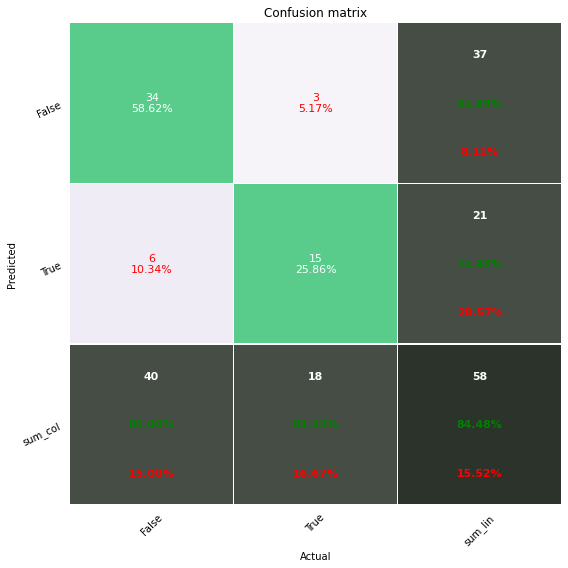

In [ ]:
#Grafické zobrazenie výsledkov. Duplikácia dát pomohla k presnejšej predikcií
dfcfm = pd.DataFrame(data=cfm, index=['False', 'True'], columns=['False', 'True'])
pretty_plot_confusion_matrix(dfcfm, cmap='PuRd')

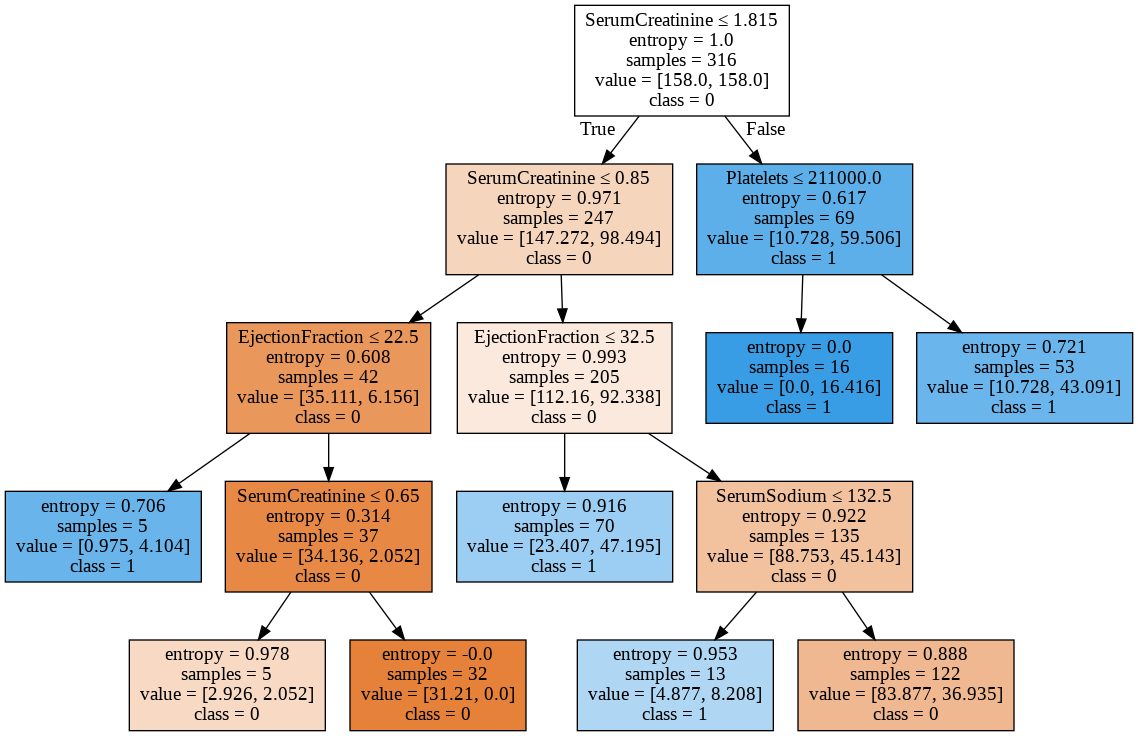

In [ ]:
#Grafické zobrazenie rozhodovacieho stromu
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=False, special_characters=True,feature_names = ['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking'] ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('tree.png')
Image(graph.create_png())

In [ ]:
#Textová forma pravidiel
r = export_text(clf, feature_names=['Age', 'Anaemia', 'CreatininePhosphokinase', 'Diabetes', 'EjectionFraction', 'HighBloodPressure', 'Platelets', 'SerumCreatinine', 'SerumSodium', 'Sex', 'Smoking'])
print(r)

|--- SerumCreatinine <= 1.81
|   |--- SerumCreatinine <= 0.85
|   |   |--- EjectionFraction <= 22.50
|   |   |   |--- class: 1
|   |   |--- EjectionFraction >  22.50
|   |   |   |--- SerumCreatinine <= 0.65
|   |   |   |   |--- class: 0
|   |   |   |--- SerumCreatinine >  0.65
|   |   |   |   |--- class: 0
|   |--- SerumCreatinine >  0.85
|   |   |--- EjectionFraction <= 32.50
|   |   |   |--- class: 1
|   |   |--- EjectionFraction >  32.50
|   |   |   |--- SerumSodium <= 132.50
|   |   |   |   |--- class: 1
|   |   |   |--- SerumSodium >  132.50
|   |   |   |   |--- class: 0
|--- SerumCreatinine >  1.81
|   |--- Platelets <= 211000.00
|   |   |--- class: 1
|   |--- Platelets >  211000.00
|   |   |--- class: 1



In [ ]:
#Modul na grafické zobrazenie confusion matice
from pandas import DataFrame
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)